<a href="https://colab.research.google.com/github/thermaty/cassini-hackathon/blob/main/coca_spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt

In [59]:
ee.Authenticate()
ee.Initialize(project='eee-therm')

In [60]:
Map = geemap.Map()
Map.setCenter(-73.05751851170075, 9.023264528918766, 12)

def mask_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0)
              .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
    return image.updateMask(mask)

def mask_other(image):
    scl = image.select('SCL')
    clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
    return image.updateMask(clear_sky_pixels)

def export_polygons_csv(features: list, output_file):
  data = []

  for feature in features:
      polygon_coordinates = feature.geometry().getInfo()['coordinates']
      polygon = Polygon(polygon_coordinates[0])

      label = feature.get('type').getInfo()

      data.append({'ID': feature.id().getInfo(), 'Label': label, 'geometry': polygon})

  gdf = gpd.GeoDataFrame(data, geometry='geometry').to_csv(output_file, index=False)
  print(f"CSV file saved to {output_file}")

def read_ee_polygon(row):
    wkt_str = wkt.loads(row['geometry'])
    polygon_coords = [[[x, y] for x, y in list(wkt_str.exterior.coords)]]
    return ee.Feature(ee.Geometry.Polygon(polygon_coords), properties={'title': row['Label']})

def calculate_mean_reflectance(feature):
    reducer = sentinel_whole_year.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10
    )
    return feature.set(reducer)

In [61]:
study_area = ee.Geometry.Polygon(
    [[
        [-73.05863431065096, 9.038639089909546],
        [-73.05863431065096, 8.989641653470498],
        [-73.00919583408844, 8.989641653470498],
        [-73.00919583408844, 9.038639089909546]
    ]]
)

sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(study_area) \
    .filterDate('2024-01-01', '2025-01-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
    .map(mask_clouds) \
    .map(mask_other)


visualization = {
    'min': 440,
    'max': 2000,
    'bands': ['B4', 'B3', 'B2']
}

sentinel_whole_year = sentinel.median().clip(study_area)

In [62]:
df = pd.read_csv('assets/features.csv')
features = list(df.apply(read_ee_polygon, axis=1))
spectral_data = ee.FeatureCollection(list(df.apply(read_ee_polygon, axis=1)))

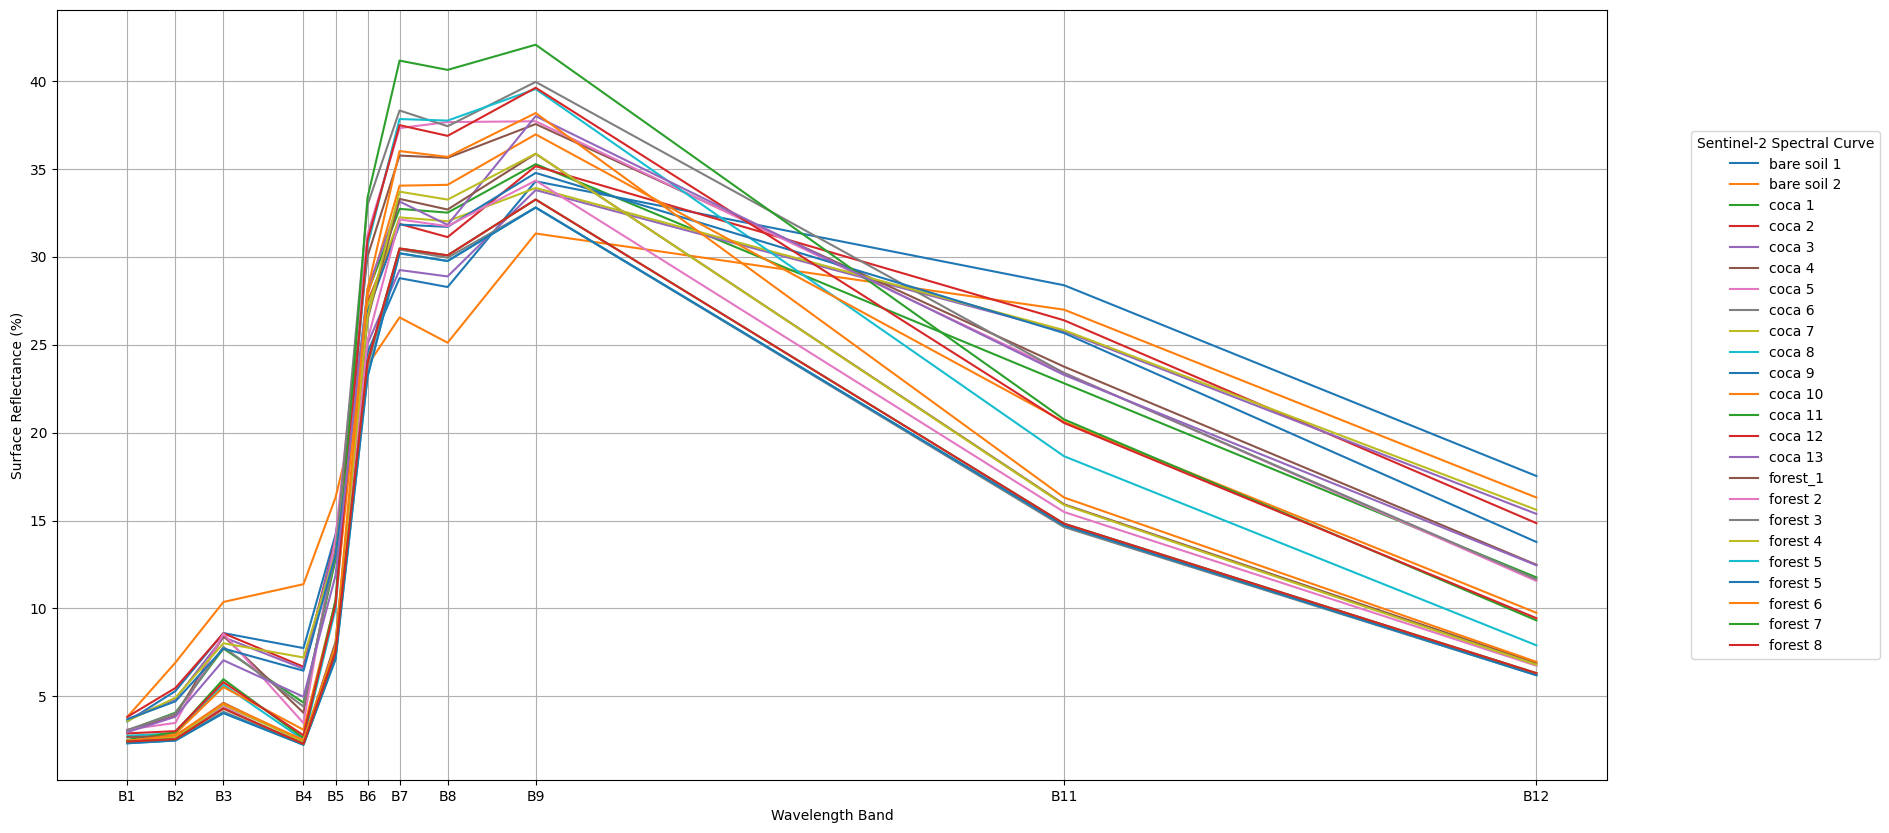

In [63]:
wavelengths_sentinel = [0.44, 0.50, 0.56, 0.66, 0.70, 0.74, 0.78, 0.84, 0.95, 1.61, 2.20]
bands_sentinel = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B11", "B12"]
mean_data = spectral_data.map(calculate_mean_reflectance)

results = mean_data.getInfo()
df_results = pd.DataFrame([feature['properties'] for feature in results['features']])

plt.figure(figsize=(20, 10))

for _, row in df_results.iterrows():
    reflectance_values = [row[band]/100.0 for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B11', 'B12']]
    plt.plot(wavelengths_sentinel, reflectance_values, label=row.get('title', 'Unknown'))

plt.legend(title='Sentinel-2 Spectral Curve', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('Wavelength Band')
plt.ylabel('Surface Reflectance (%)')
plt.grid(True)
plt.xticks(wavelengths_sentinel, labels=bands_sentinel)
plt.show()